In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2


In [2]:
df=pd.read_csv('oath_v1.1/classifications/classifications-edited.csv')
df.head()

,class2,class6,picNum,picType,rotAng
0,0,2,1,discrete,334
1,0,2,2,discrete,29
2,0,2,3,discrete,355
3,0,0,4,arc,118
4,0,0,5,arc,55


In [3]:
import os
import numpy as np
import cv2

# Function to add salt-and-pepper noise
def add_salt_and_pepper_noise(image, salt_prob=0.02, pepper_prob=0.02):
    noisy_image = np.copy(image)
    total_pixels = image.size

    # Add salt noise (white pixels)
    num_salt = int(salt_prob * total_pixels)
    salt_coords = [np.random.randint(0, dim, num_salt) for dim in image.shape[:2]]
    noisy_image[salt_coords[0], salt_coords[1]] = 255

    # Add pepper noise (black pixels)
    num_pepper = int(pepper_prob * total_pixels)
    pepper_coords = [np.random.randint(0, dim, num_pepper) for dim in image.shape[:2]]
    noisy_image[pepper_coords[0], pepper_coords[1]] = 0

    return noisy_image

# Base path for original and noisy images
original_folder = "oath_v1.1/images/cropped_scaled/"
noisy_folder = "oath_v1.1/images/cropped_scaled_sp/"  # Folder for salt-and-pepper noisy images

# Create the new folder if it doesn't exist
os.makedirs(noisy_folder, exist_ok=True)

# Process each image in the dataset
for _, row in df.iterrows():
    pic_num = row['picNum']  # Replace 'picNum' with the appropriate column name
    image_path = os.path.join(original_folder, f"{pic_num:05d}.png")  # Adjust filename format if needed
    noisy_image_path = os.path.join(noisy_folder, f"{pic_num:05d}.png")
    
    # Read the original image
    image = cv2.imread(image_path)
    if image is not None:
        # Add salt-and-pepper noise
        noisy_image = add_salt_and_pepper_noise(image)
        
        # Save the noisy image
        cv2.imwrite(noisy_image_path, noisy_image)
    else:
        print(f"Could not read image: {image_path}")

print(f"All noisy images saved to {noisy_folder}")

All noisy images saved to oath_v1.1/images/cropped_scaled_sp/


##### Feature Extraction on the basis of specific feature and different angles

In [4]:
from skimage.feature import graycomatrix, graycoprops

rough_df = pd.DataFrame(df)

# Image folder path
image_folder = 'oath_v1.1/images/cropped_scaled_sp'

# Define angles and distance for GLCM computation
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # 0, 45, 90, 135 degrees
distances = [1]

# Initialize lists to store features
contrast_list = {angle: [] for angle in angles}
dissimilarity_list = {angle: [] for angle in angles}
homogeneity_list = {angle: [] for angle in angles}
energy_list = {angle: [] for angle in angles}
correlation_list = {angle: [] for angle in angles}

# Loop through each row in the dataframe
for index, row in rough_df.iterrows():
    pic_num = str(row['picNum']).zfill(5)  # Format picNum as 5 digits
    image_path = f"{image_folder}/{pic_num}.png"
    
    # Load the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if img is not None:
        # Compute GLCM for each angle
        for angle in angles:
            glcm = graycomatrix(img, distances=distances, angles=[angle], levels=256, symmetric=True, normed=True)
            
            # Compute texture properties
            contrast = graycoprops(glcm, prop='contrast')[0, 0]
            dissimilarity = graycoprops(glcm, prop='dissimilarity')[0, 0]
            homogeneity = graycoprops(glcm, prop='homogeneity')[0, 0]
            energy = graycoprops(glcm, prop='energy')[0, 0]
            correlation = graycoprops(glcm, prop='correlation')[0, 0]
            
            # Append the features to the lists
            contrast_list[angle].append(contrast)
            dissimilarity_list[angle].append(dissimilarity)
            homogeneity_list[angle].append(homogeneity)
            energy_list[angle].append(energy)
            correlation_list[angle].append(correlation)
    else:
        # In case of missing image, append NaNs
        for angle in angles:
            contrast_list[angle].append(np.nan)
            dissimilarity_list[angle].append(np.nan)
            homogeneity_list[angle].append(np.nan)
            energy_list[angle].append(np.nan)
            correlation_list[angle].append(np.nan)

# Add the computed features to the dataframe
for angle in angles:
    angle_degree = int(np.degrees(angle))  # Convert radian to degrees
    rough_df[f'contrast_{angle_degree}'] = contrast_list[angle]
    rough_df[f'dissimilarity_{angle_degree}'] = dissimilarity_list[angle]
    rough_df[f'homogeneity_{angle_degree}'] = homogeneity_list[angle]
    rough_df[f'energy_{angle_degree}'] = energy_list[angle]
    rough_df[f'correlation_{angle_degree}'] = correlation_list[angle]

# Display the updated dataframe
rough_df.head(10)

,class2,class6,picNum,picType,rotAng,contrast_0,dissimilarity_0,homogeneity_0,energy_0,correlation_0,...,contrast_90,dissimilarity_90,homogeneity_90,energy_90,correlation_90,contrast_135,dissimilarity_135,homogeneity_135,energy_135,correlation_135
0,0,2,1,discrete,334,5992.832583,29.673330,0.460618,0.386991,0.194455,...,5967.255147,29.645466,0.461129,0.387793,0.197815,5936.592126,29.617116,0.456569,0.384560,0.201320
1,0,2,2,discrete,29,5956.468030,29.109360,0.470525,0.387940,0.182371,...,5989.686167,29.265702,0.467846,0.388155,0.177978,5960.141638,29.310142,0.464789,0.385206,0.181692
2,0,2,3,discrete,355,5868.793290,29.478094,0.460356,0.387866,0.218890,...,5896.919669,29.685631,0.458038,0.387488,0.215445,5905.190342,29.789865,0.454889,0.384850,0.214110
3,0,0,4,arc,118,5848.946844,30.123866,0.447854,0.387147,0.231969,...,5832.415839,30.178278,0.446464,0.387121,0.234564,5817.238262,30.184760,0.443492,0.384286,0.236178
4,0,0,5,arc,55,5856.918413,30.184957,0.447652,0.388027,0.232047,...,5801.170604,30.107307,0.446261,0.388805,0.238304,5828.768274,30.281015,0.443826,0.385571,0.235008
5,0,1,6,diffuse,12,5836.508073,31.020267,0.438772,0.387350,0.254272,...,5805.844256,30.961137,0.439276,0.388142,0.258190,5819.481922,31.146482,0.434294,0.384524,0.256268
6,0,1,7,diffuse,334,5779.009926,30.944547,0.437312,0.386734,0.271769,...,5769.553202,31.013802,0.436388,0.387248,0.273022,5795.941669,31.197678,0.432871,0.383863,0.269717
7,0,1,8,diffuse,29,5793.842004,31.347273,0.433768,0.387198,0.259795,...,5850.461320,31.573055,0.433979,0.387339,0.253143,5804.501115,31.479477,0.430708,0.384585,0.258744
8,0,1,9,diffuse,355,5747.853401,31.303064,0.434858,0.388235,0.263081,...,5792.642708,31.452328,0.432913,0.387982,0.257854,5733.805459,31.366797,0.430844,0.385131,0.264609
9,0,1,10,diffuse,24,5784.005622,31.360401,0.435319,0.387631,0.261133,...,5833.198284,31.619393,0.434316,0.387982,0.255172,5833.213856,31.663068,0.430836,0.385000,0.254584


In [5]:
#  DEFINNG TEST DATA
from skimage.feature import graycomatrix, graycoprops


# Image folder path for test data
test_image_folder = '/Users/nishchayaroy/Desktop/ML_final_sub/final_notebooks/Dataset2/arc_png'


# Define angles and distances for GLCM computation
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # 0, 45, 90, 135 degrees
distances = [1]


# Initialize lists to store features
contrast_list = {angle: [] for angle in angles}
dissimilarity_list = {angle: [] for angle in angles}
homogeneity_list = {angle: [] for angle in angles}
energy_list = {angle: [] for angle in angles}
correlation_list = {angle: [] for angle in angles}


# List all PNG files in the test image folder
test_images = [f for f in os.listdir(test_image_folder) if f.endswith('.png')]


# Initialize a dataframe to store results
test_df = pd.DataFrame({'image_name': test_images})


# Process each test image
for image_name in test_images:
   image_path = os.path.join(test_image_folder, image_name)
  
   # Load the image in grayscale
   img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
  
   if img is not None:
       # Compute GLCM for each angle
       for angle in angles:
           glcm = graycomatrix(img, distances=distances, angles=[angle], levels=256, symmetric=True, normed=True)
          
           # Compute texture properties
           contrast = graycoprops(glcm, prop='contrast')[0, 0]
           dissimilarity = graycoprops(glcm, prop='dissimilarity')[0, 0]
           homogeneity = graycoprops(glcm, prop='homogeneity')[0, 0]
           energy = graycoprops(glcm, prop='energy')[0, 0]
           correlation = graycoprops(glcm, prop='correlation')[0, 0]
          
           # Append the features to the lists
           contrast_list[angle].append(contrast)
           dissimilarity_list[angle].append(dissimilarity)
           homogeneity_list[angle].append(homogeneity)
           energy_list[angle].append(energy)
           correlation_list[angle].append(correlation)
   else:
       # In case of missing or unreadable image, append NaNs
       for angle in angles:
           contrast_list[angle].append(np.nan)
           dissimilarity_list[angle].append(np.nan)
           homogeneity_list[angle].append(np.nan)
           energy_list[angle].append(np.nan)
           correlation_list[angle].append(np.nan)


# Add the computed features to the test dataframe
for angle in angles:
   angle_degree = int(np.degrees(angle))  # Convert radian to degrees
   test_df[f'contrast_{angle_degree}'] = contrast_list[angle]
   test_df[f'dissimilarity_{angle_degree}'] = dissimilarity_list[angle]
   test_df[f'homogeneity_{angle_degree}'] = homogeneity_list[angle]
   test_df[f'energy_{angle_degree}'] = energy_list[angle]
   test_df[f'correlation_{angle_degree}'] = correlation_list[angle]


# Display the updated test dataframe
# test_df['class2'] = 0
# test_df['rotAng'] = 0
test_df = test_df.drop(columns=['image_name'])
# print(test_df.head())

##### Random Forest Model Classification

In [6]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Assuming your dataframe is named df and is already loaded
# df contains the numerical features and class6 is the target

# Separate input features (X) and target variable (y)
X = rough_df.drop(columns=['class6', 'picNum', 'picType'])  # Drop non-numeric and non-feature columns
y = rough_df['class6']  # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 79.60%

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.34      0.43       185
           1       0.76      0.74      0.75       284
           2       0.67      0.83      0.74       363
           3       0.95      0.88      0.91       196
           4       0.93      0.94      0.94       164
           5       0.93      0.98      0.96       264

    accuracy                           0.80      1456
   macro avg       0.80      0.78      0.79      1456
weighted avg       0.79      0.80      0.79      1456



##### Stratified CV technique with 100 folds using RF classifier

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report

# Assuming your dataframe is named rough_df
# Separate input features (X) and target variable (y)
X = rough_df.drop(columns=['class6', 'picNum', 'picType'])  # Drop non-numeric and non-feature columns
y = rough_df['class6']  # Target variable

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Define Stratified K-Fold cross-validation
skf = StratifiedKFold(n_splits=100, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(rf_model, X, y, cv=skf, scoring='accuracy')

# Print the results
print(f"Cross-validated accuracy scores: {cv_scores}")
print(f"Mean cross-validated accuracy: {cv_scores.mean() * 100:.2f}%")
print(f"Standard deviation of accuracy: {cv_scores.std() * 100:.2f}%")

Cross-validated accuracy scores: [0.83050847 0.81355932 0.74576271 0.77966102 0.83050847 0.77966102
 0.76271186 0.76271186 0.79661017 0.77966102 0.93220339 0.72881356
 0.83050847 0.72881356 0.84745763 0.81355932 0.84745763 0.76271186
 0.81355932 0.84745763 0.71186441 0.77966102 0.81355932 0.77966102
 0.81034483 0.74137931 0.82758621 0.84482759 0.82758621 0.81034483
 0.79310345 0.77586207 0.77586207 0.75862069 0.79310345 0.77586207
 0.82758621 0.77586207 0.77586207 0.81034483 0.82758621 0.79310345
 0.84482759 0.79310345 0.77586207 0.82758621 0.77586207 0.77586207
 0.77586207 0.75862069 0.75862069 0.82758621 0.74137931 0.77586207
 0.75862069 0.86206897 0.81034483 0.77586207 0.86206897 0.81034483
 0.79310345 0.74137931 0.81034483 0.84482759 0.77586207 0.84482759
 0.86206897 0.79310345 0.77586207 0.86206897 0.9137931  0.75862069
 0.81034483 0.74137931 0.82758621 0.82758621 0.82758621 0.82758621
 0.87931034 0.82758621 0.79310345 0.79310345 0.74137931 0.77586207
 0.86206897 0.81034483 0.8448

In [8]:
X = rough_df.drop(columns=['class2','class6','rotAng', 'picNum', 'picType'])  # Drop non-numeric and non-feature columns
y = rough_df['class6']  # Target variable


In [9]:
from sklearn.preprocessing import StandardScaler

# Standardize the features for SVM and GMM
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Scale features

##### NB classifier

In [10]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold, cross_val_score


skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)  # Adjust `n_splits` as needed

# Initialize Gaussian Naive Bayes
nb_model = GaussianNB()

# Perform cross-validation
cv_scores_nb = cross_val_score(nb_model, X, y, cv=skf, scoring='accuracy')

# Print results
print(f"Naive Bayes Cross-validated accuracy scores: {cv_scores_nb}")
print(f"Mean Cross-validated accuracy: {cv_scores_nb.mean() * 100:.2f}%")
print(f"Standard deviation of accuracy: {cv_scores_nb.std() * 100:.2f}%")

Naive Bayes Cross-validated accuracy scores: [0.51629503 0.54202401 0.50943396 0.52487136 0.5257732  0.50515464
 0.50515464 0.48281787 0.50171821 0.51890034]
Mean Cross-validated accuracy: 51.32%
Standard deviation of accuracy: 1.54%


In [14]:
nb_model.fit(X, y)

test_scaled = scaler.transform(test_df)
test_y = nb_model.predict(test_scaled)
print(test_y)
count_zero = np.sum(test_y == 0)


# Calculate the total number of predictions
total_predictions = len(test_y)


# Calculate the percentage of 0 values in test_y
percentage_zero = (count_zero / total_predictions) * 100


# Print the result
print(f"Percentage of 0 values in test_y: {percentage_zero:.2f}%")


[4 4 4 ... 4 4 4]
Percentage of 0 values in test_y: 0.00%


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


##### SVM Classifer

In [11]:
from sklearn.svm import SVC

# Initialize SVM with RBF kernel
svm_model = SVC(kernel='rbf', random_state=42)

# Perform cross-validation
cv_scores_svm = cross_val_score(svm_model, X_scaled, y, cv=skf, scoring='accuracy')

# Print results
print(f"SVM Cross-validated accuracy scores: {cv_scores_svm}")
print(f"Mean Cross-validated accuracy: {cv_scores_svm.mean() * 100:.2f}%")
print(f"Standard deviation of accuracy: {cv_scores_svm.std() * 100:.2f}%")

SVM Cross-validated accuracy scores: [0.61063465 0.65523156 0.63979417 0.60548885 0.60996564 0.61683849
 0.64948454 0.63402062 0.60996564 0.64776632]
Mean Cross-validated accuracy: 62.79%
Standard deviation of accuracy: 1.83%


In [16]:
svm_model.fit(X, y)

test_scaled = scaler.transform(test_df)
test_y = svm_model.predict(test_scaled)
print(test_y)
count_zero = np.sum(test_y == 0)


# Calculate the total number of predictions
total_predictions = len(test_y)


# Calculate the percentage of 0 values in test_y
percentage_zero = (count_zero / total_predictions) * 100


# Print the result
print(f"Percentage of 0 values in test_y: {percentage_zero:.2f}%")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


[1 1 1 ... 1 1 1]
Percentage of 0 values in test_y: 0.00%


##### GMM classifier

In [24]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
import numpy as np

# Train a GMM for each class
class_gmm_models = {}
unique_classes = np.unique(y)

for cls in unique_classes:
    gmm = GaussianMixture(n_components=10, covariance_type='full', random_state=42)
    class_gmm_models[cls] = gmm.fit(X_scaled[y == cls])

# Predict the class for each sample
def predict_gmm(models, data):
    likelihoods = np.array([model.score_samples(data) for model in models.values()]).T
    return np.array(list(models.keys()))[np.argmax(likelihoods, axis=1)]

gmm_predictions = predict_gmm(class_gmm_models, X_scaled)
gmm_accuracy = accuracy_score(y, gmm_predictions)

# Print results
print(f"GMM Accuracy: {gmm_accuracy * 100:.2f}%")

GMM Accuracy: 90.23%


In [26]:
test_scaled = scaler.transform(test_df)
gmm_predictions = predict_gmm(class_gmm_models, test_scaled)
print(gmm_predictions)
test_y = gmm_predictions
count_zero = np.sum(test_y == 0)


# Calculate the total number of predictions
total_predictions = len(test_y)


# Calculate the percentage of 0 values in test_y
percentage_zero = (count_zero / total_predictions) * 100


# Print the result
print(f"Accuracy of GMM model(noise data): {percentage_zero:.2f}%")

[1 1 1 ... 1 1 1]
Accuracy of GMM model(noise data): 0.00%


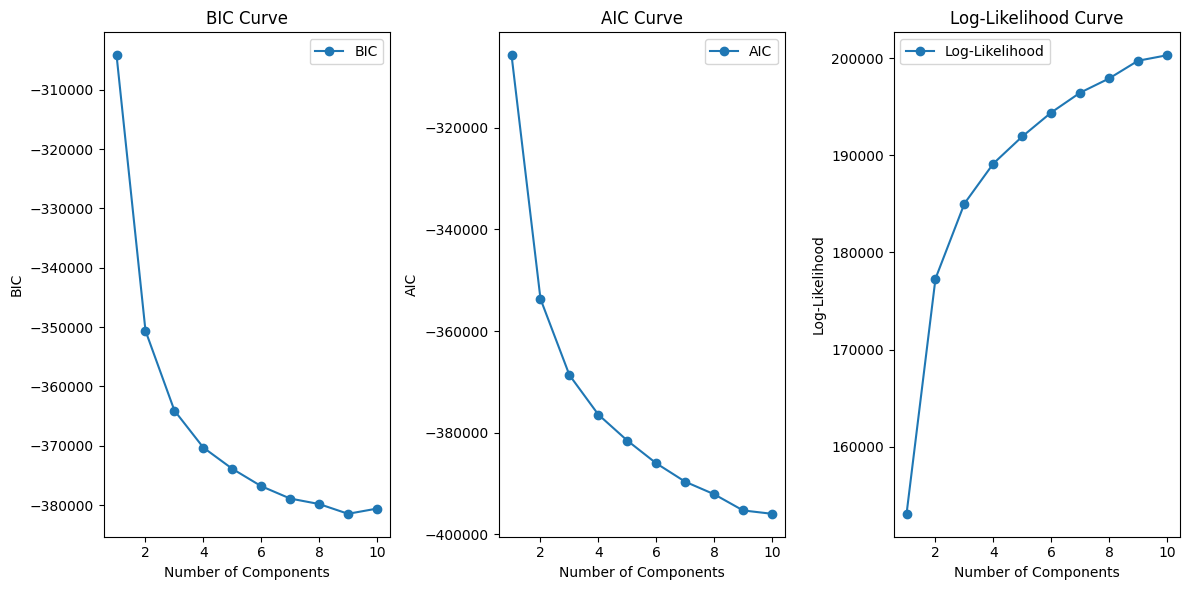

Optimal number of components (BIC): 9
Optimal number of components (AIC): 10


In [19]:
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# Example dataset (replace this with your actual data)
data = X_scaled # Replace with your features

# Range of components to test
n_components_range = range(1, 11)  # Test 1 to 10 components

# Store BIC, AIC, and log-likelihood values
bic_scores = []
aic_scores = []
log_likelihoods = []

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(data)
    
    # Append BIC, AIC, and log-likelihood values
    bic_scores.append(gmm.bic(data))
    aic_scores.append(gmm.aic(data))
    log_likelihoods.append(gmm.score(data) * len(data))  # Total log-likelihood

# Plot BIC, AIC, and log-likelihood
plt.figure(figsize=(12, 6))

# Plot BIC
plt.subplot(1, 3, 1)
plt.plot(n_components_range, bic_scores, marker='o', label='BIC')
plt.xlabel('Number of Components')
plt.ylabel('BIC')
plt.title('BIC Curve')
plt.legend()

# Plot AIC
plt.subplot(1, 3, 2)
plt.plot(n_components_range, aic_scores, marker='o', label='AIC')
plt.xlabel('Number of Components')
plt.ylabel('AIC')
plt.title('AIC Curve')
plt.legend()

# Plot Log-Likelihood
plt.subplot(1, 3, 3)
plt.plot(n_components_range, log_likelihoods, marker='o', label='Log-Likelihood')
plt.xlabel('Number of Components')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood Curve')
plt.legend()

plt.tight_layout()
plt.show()

# Find the best n_components based on the lowest BIC or AIC
optimal_bic = n_components_range[np.argmin(bic_scores)]
optimal_aic = n_components_range[np.argmin(aic_scores)]

print(f"Optimal number of components (BIC): {optimal_bic}")
print(f"Optimal number of components (AIC): {optimal_aic}")